In [1]:
#from google.colab import drive
#drive.mount('/gdrive')

In [2]:
#%cd /gdrive/My Drive/Stage

In [3]:
#%ls KGAT_notebooks/

In [4]:
import os
import sys
import random
from time import time

import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# VS code
from KGAT.model_kgat import  KGAT
from KGAT.log_helper import *
from KGAT.metrics import *
from KGAT.model_helper import *
from KGAT.loader_kgat import DataLoaderKGAT

torch.cuda.empty_cache()

torch.manual_seed(42)

# Import of raw data
Will be useful for visualization later on

In [5]:
import pandas as pd
import ast
import os

def load_raw(data_dir):
    data = pd.read_csv(os.path.join(data_dir,'movielens_final.csv'), index_col=0)
    data.loc[data.starring.isna(),'starring'] = ''
    data.loc[data.directedBy.isna(),'directedBy'] = ''
    data['genres'] = data['genres'].apply(ast.literal_eval)
    data['starring'] = data['starring'].apply(lambda x: [i.strip() for i in x.split(',')])
    data['starring'] = data['starring'].apply(lambda x: [s for s in x if s != ''])
    data['directedBy'] = data['directedBy'].apply(lambda x: [i.strip() for i in x.split(',')])
    data['directedBy'] = data['directedBy'].apply(lambda x: [s for s in x if s != ''])
    return data

In [6]:
df = load_raw(data_dir = 'KGAT data (10 in test, encoders)')
item_df = df.drop_duplicates(subset=['movieId'])

In [7]:
### Evaluate, Train, Predict definition

def evaluate(model, dataloader, Ks, device):
    test_batch_size = dataloader.test_batch_size
    train_user_dict = dataloader.train_user_dict
    test_user_dict = dataloader.test_user_dict

    model.eval()

    user_ids = list(test_user_dict.keys())
    user_ids_batches = [user_ids[i: i + test_batch_size] for i in range(0, len(user_ids), test_batch_size)]
    user_ids_batches = [torch.LongTensor(d) for d in user_ids_batches]

    n_items = dataloader.n_items
    item_ids = torch.arange(n_items, dtype=torch.long).to(device)

    cf_scores = []
    metric_names = ['precision', 'recall', 'ndcg']
    metrics_dict = {k: {m: [] for m in metric_names} for k in Ks}

    with tqdm(total=len(user_ids_batches), desc='Evaluating Iteration') as pbar:
        for batch_user_ids in user_ids_batches:
            batch_user_ids = batch_user_ids.to(device)

            with torch.no_grad():
                batch_scores = model(batch_user_ids, item_ids, mode='predict')       # (n_batch_users, n_items)

            batch_scores = batch_scores.cpu()
            batch_metrics = calc_metrics_at_k(batch_scores, train_user_dict, test_user_dict, batch_user_ids.cpu().numpy(), item_ids.cpu().numpy(), Ks)

            cf_scores.append(batch_scores.numpy())
            for k in Ks:
                for m in metric_names:
                    metrics_dict[k][m].append(batch_metrics[k][m])
            pbar.update(1)

    cf_scores = np.concatenate(cf_scores, axis=0)
    for k in Ks:
        for m in metric_names:
            metrics_dict[k][m] = np.concatenate(metrics_dict[k][m]).mean()
    return cf_scores, metrics_dict


def train(args):
    # seed
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    log_save_id = create_log_id(args.save_dir)
    logging_config(folder=args.save_dir, name='log{:d}'.format(log_save_id), no_console=False)
    logging.info(args)

    # GPU / CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load data
    data = DataLoaderKGAT(args, logging)
    if args.use_pretrain == 1:
        user_pre_embed = torch.tensor(data.user_pre_embed)
        item_pre_embed = torch.tensor(data.item_pre_embed)
    else:
        user_pre_embed, item_pre_embed = None, None

    # construct model & optimizer
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations, data.A_in, user_pre_embed, item_pre_embed)
    if args.use_pretrain == 2:
        model = load_model(model, args.pretrain_model_path)

    model.to(device)
    logging.info(model)

    cf_optimizer = optim.Adam(model.parameters(), lr=args.lr)
    kg_optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # initialize metrics
    best_epoch = -1
    best_recall = 0

    Ks = eval(args.Ks)
    k_min = min(Ks)
    k_max = max(Ks)

    epoch_list = []
    metrics_list = {k: {'precision': [], 'recall': [], 'ndcg': []} for k in Ks}

    # train model
    for epoch in range(1, args.n_epoch + 1):
        time0 = time()
        model.train()

        # train cf
        time1 = time()
        cf_total_loss = 0
        n_cf_batch = data.n_cf_train // data.cf_batch_size + 1

        for iter in range(1, n_cf_batch + 1):
            time2 = time()
            cf_batch_user, cf_batch_pos_item, cf_batch_neg_item = data.generate_cf_batch(data.train_user_dict, data.cf_batch_size)
            cf_batch_user = cf_batch_user.to(device)
            cf_batch_pos_item = cf_batch_pos_item.to(device)
            cf_batch_neg_item = cf_batch_neg_item.to(device)

            cf_batch_loss = model(cf_batch_user, cf_batch_pos_item, cf_batch_neg_item, mode='train_cf')

            if np.isnan(cf_batch_loss.cpu().detach().numpy()):
                logging.info('ERROR (CF Training): Epoch {:04d} Iter {:04d} / {:04d} Loss is nan.'.format(epoch, iter, n_cf_batch))
                sys.exit()

            cf_batch_loss.backward()
            cf_optimizer.step()
            cf_optimizer.zero_grad()
            cf_total_loss += cf_batch_loss.item()
            
            if (iter % args.cf_print_every) == 0:
                logging.info('CF Training: Epoch {:04d} Iter {:04d} / {:04d} | Time {:.1f}s | Iter Loss {:.4f} | Iter Mean Loss {:.4f}'.format(epoch, iter, n_cf_batch, time() - time2, cf_batch_loss.item(), cf_total_loss / iter))
        #logging.info('CF Training: Epoch {:04d} Total Iter {:04d} | Total Time {:.1f}s | Iter Mean Loss {:.4f}'.format(epoch, n_cf_batch, time() - time1, cf_total_loss / n_cf_batch))
        # train kg
        time3 = time()
        kg_total_loss = 0
        n_kg_batch = data.n_kg_train // data.kg_batch_size + 1

        for iter in range(1, n_kg_batch + 1):
            time4 = time()
            kg_batch_head, kg_batch_relation, kg_batch_pos_tail, kg_batch_neg_tail = data.generate_kg_batch(data.train_kg_dict, data.kg_batch_size, data.n_users_entities)
            kg_batch_head = kg_batch_head.to(device)
            kg_batch_relation = kg_batch_relation.to(device)
            kg_batch_pos_tail = kg_batch_pos_tail.to(device)
            kg_batch_neg_tail = kg_batch_neg_tail.to(device)

            kg_batch_loss = model(kg_batch_head, kg_batch_relation, kg_batch_pos_tail, kg_batch_neg_tail, mode='train_kg')

            if np.isnan(kg_batch_loss.cpu().detach().numpy()):
                logging.info('ERROR (KG Training): Epoch {:04d} Iter {:04d} / {:04d} Loss is nan.'.format(epoch, iter, n_kg_batch))
                sys.exit()

            kg_batch_loss.backward()
            kg_optimizer.step()
            kg_optimizer.zero_grad()
            kg_total_loss += kg_batch_loss.item()

            if (iter % args.kg_print_every) == 0:
                logging.info('KG Training: Epoch {:04d} Iter {:04d} / {:04d} | Time {:.1f}s | Iter Loss {:.4f} | Iter Mean Loss {:.4f}'.format(epoch, iter, n_kg_batch, time() - time4, kg_batch_loss.item(), kg_total_loss / iter))
        #logging.info('KG Training: Epoch {:04d} Total Iter {:04d} | Total Time {:.1f}s | Iter Mean Loss {:.4f}'.format(epoch, n_kg_batch, time() - time3, kg_total_loss / n_kg_batch))

        # update attention
        time5 = time()
        h_list = data.h_list.to(device)
        t_list = data.t_list.to(device)
        r_list = data.r_list.to(device)
        relations = list(data.laplacian_dict.keys())
        model(h_list, t_list, r_list, relations, mode='update_att')
        logging.info('Update Attention: Epoch {:04d} | Total Time {:.1f}s'.format(epoch, time() - time5))

        logging.info('CF + KG Training: Epoch {:04d} | Total Time {:.1f}s'.format(epoch, time() - time0))

        # evaluate cf
        if (epoch % args.evaluate_every) == 0 or epoch == args.n_epoch:
            time6 = time()
            _, metrics_dict = evaluate(model, data, Ks, device)
            logging.info('CF Evaluation: Epoch {:04d} | Total Time {:.1f}s | Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
                epoch, time() - time6, metrics_dict[k_min]['precision'], metrics_dict[k_max]['precision'], metrics_dict[k_min]['recall'], metrics_dict[k_max]['recall'], metrics_dict[k_min]['ndcg'], metrics_dict[k_max]['ndcg']))

            epoch_list.append(epoch)
            for k in Ks:
                for m in ['precision', 'recall', 'ndcg']:
                    metrics_list[k][m].append(metrics_dict[k][m])
            best_recall, should_stop = early_stopping(metrics_list[k_min]['recall'], args.stopping_steps)

            if should_stop:
                break

            if metrics_list[k_min]['recall'].index(best_recall) == len(epoch_list) - 1:
                save_model(model, args.save_dir, epoch, best_epoch)
                logging.info('Save model on epoch {:04d}!'.format(epoch))
                best_epoch = epoch

    # save metrics
    metrics_df = [epoch_list]
    metrics_cols = ['epoch_idx']
    for k in Ks:
        for m in ['precision', 'recall', 'ndcg']:
            metrics_df.append(metrics_list[k][m])
            metrics_cols.append('{}@{}'.format(m, k))
    metrics_df = pd.DataFrame(metrics_df).transpose()
    metrics_df.columns = metrics_cols
    metrics_df.to_csv(args.save_dir + '/metrics.tsv', sep='\t', index=False)

    # print best metrics
    best_metrics = metrics_df.loc[metrics_df['epoch_idx'] == best_epoch].iloc[0].to_dict()
    logging.info('Best CF Evaluation: Epoch {:04d} | Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
        int(best_metrics['epoch_idx']), best_metrics['precision@{}'.format(k_min)], best_metrics['precision@{}'.format(k_max)], best_metrics['recall@{}'.format(k_min)], best_metrics['recall@{}'.format(k_max)], best_metrics['ndcg@{}'.format(k_min)], best_metrics['ndcg@{}'.format(k_max)]))


def predict(args):
    # GPU / CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # load data
    data = DataLoaderKGAT(args, logging)

    # load model
    model = KGAT(args, data.n_users, data.n_entities, data.n_relations)
    model = load_model(model, args.pretrain_model_path)
    model.to(device)

    # predict
    Ks = eval(args.Ks)
    k_min = min(Ks)
    k_max = max(Ks)

    cf_scores, metrics_dict = evaluate(model, data, Ks, device)
    np.save(args.save_dir + 'cf_scores.npy', cf_scores)
    print('CF Evaluation: Precision [{:.4f}, {:.4f}], Recall [{:.4f}, {:.4f}], NDCG [{:.4f}, {:.4f}]'.format(
        metrics_dict[k_min]['precision'], metrics_dict[k_max]['precision'], metrics_dict[k_min]['recall'], metrics_dict[k_max]['recall'], metrics_dict[k_min]['ndcg'], metrics_dict[k_max]['ndcg']))


In [8]:
# Defining data directory !!
data_dir = 'KGAT data (10 in test, encoders)'

In [9]:
import argparse

parser = argparse.ArgumentParser(description="Run KGAT.")

parser.add_argument('--seed', type=int, default=2019,
                    help='Random seed.')

parser.add_argument('--data_name', nargs='?', default='',
                    help='Choose a dataset from {movielens}')
parser.add_argument('--data_dir', nargs='?', default=data_dir,
                    help='Input data path.')

parser.add_argument('--use_pretrain', type=int, default=0,
                    help='0: No pretrain, 1: Pretrain with the learned embeddings, 2: Pretrain with stored model.')
parser.add_argument('--pretrain_embedding_dir', nargs='?', default='datasets/pretrain/',
                    help='Path of learned embeddings.')
parser.add_argument('--pretrain_model_path', nargs='?', default='trained_model/model.pth',
                    help='Path of stored model.')

parser.add_argument('--cf_batch_size', type=int, default=1024,
                    help='CF batch size.')
parser.add_argument('--kg_batch_size', type=int, default=2048,
                    help='KG batch size.')
parser.add_argument('--test_batch_size', type=int, default=100,
                    help='Test batch size (the user number to test every batch).')

parser.add_argument('--embed_dim', type=int, default=64,
                    help='User / entity Embedding size.')
parser.add_argument('--relation_dim', type=int, default=64,
                    help='Relation Embedding size.')

parser.add_argument('--laplacian_type', type=str, default='random-walk',
                    help='Specify the type of the adjacency (laplacian) matrix from {symmetric, random-walk}.')
parser.add_argument('--aggregation_type', type=str, default='bi-interaction',
                    help='Specify the type of the aggregation layer from {gcn, graphsage, bi-interaction}.')
parser.add_argument('--conv_dim_list', nargs='?', default='[64, 32, 16]',
                    help='Output sizes of every aggregation layer.')
parser.add_argument('--mess_dropout', nargs='?', default='[0.1, 0.1, 0.1]',
                    help='Dropout probability w.r.t. message dropout for each deep layer. 0: no dropout.')

parser.add_argument('--kg_l2loss_lambda', type=float, default=1e-5,
                    help='Lambda when calculating KG l2 loss.')
parser.add_argument('--cf_l2loss_lambda', type=float, default=1e-5,
                    help='Lambda when calculating CF l2 loss.')

parser.add_argument('--lr', type=float, default=0.0001,
                    help='Learning rate.')
parser.add_argument('--n_epoch', type=int, default=1000,
                    help='Number of epoch.')
parser.add_argument('--stopping_steps', type=int, default=10,
                    help='Number of epoch for early stopping')

parser.add_argument('--cf_print_every', type=int, default=1,
                    help='Iter interval of printing CF loss.')
parser.add_argument('--kg_print_every', type=int, default=1,
                    help='Iter interval of printing KG loss.')
parser.add_argument('--evaluate_every', type=int, default=10,
                    help='Epoch interval of evaluating CF.')

parser.add_argument('--Ks', nargs='?', default='[20, 40, 60, 80, 100]',
                    help='Calculate metric@K when evaluating.')

args = parser.parse_args(['--seed', '2019'])

###################################################################################################


args.cf_print_every=100 #to avoid too many prints during training
args.kg_print_every=100
args.Ks = '[10,20]'

# As best from AutoML for now
best_config = {'lr': 0.0010719307557061938, 'embed_dim': 64, 'relation_dim': 32, 'cf_batch_size': 256, 
                     'kg_batch_size': 1024, 'laplacian_type': 'random-walk', 'aggregation_type': 'bi-interaction', 
                     'conv_dim_list': '[32, 16, 8]', 'mess_dropout': '[0.2, 0.2, 0.2]', 'kg_l2loss_lambda': 2.0025035638453267e-05, 
                     'cf_l2loss_lambda': 0.0005181251385480587}

args.lr = best_config['lr']
args.embed_dim = best_config['embed_dim']
args.relation_dim = best_config['relation_dim']
args.cf_batch_size = 128 #best_config['cf_batch_size']
args.kg_batch_size = 512 #best_config['kg_batch_size']
args.laplacian_type = best_config['laplacian_type']
args.aggregation_type = best_config['aggregation_type']
args.conv_dim_list = best_config['conv_dim_list']
args.mess_dropout = best_config['mess_dropout']
args.kg_l2loss_lambda = best_config['kg_l2loss_lambda']
args.cf_l2loss_lambda = best_config['cf_l2loss_lambda']


###################################################################################################

save_dir = 'trained_model/KGAT/{}/embed-dim{}_relation-dim{}_{}_{}_{}_lr{}_pretrain{}/'.format(
    args.data_name, args.embed_dim, args.relation_dim, args.laplacian_type, args.aggregation_type,
    '-'.join([str(i) for i in eval(args.conv_dim_list)]), args.lr, args.use_pretrain)
args.save_dir = save_dir

save_dir = 'trained_model/KGAT/bestAutoML100'
args.save_dir = save_dir

In [10]:
# Number of layers L
print(len(eval('[64, 32, 16, 8]')))
print(len(eval('[64, 32, 16]'))) #args.conv_dim_list
"""
# Prova
best_config = {'lr': 0.0010719307557061938, 'embed_dim': 64, 'relation_dim': 32, 'cf_batch_size': 256, 
                     'kg_batch_size': 1024, 'laplacian_type': 'random-walk', 'aggregation_type': 'bi-interaction', 
                     'conv_dim_list': '[64, 32, 16, 8]', 'mess_dropout': '[0.2, 0.2, 0.2, 0.2]', 'kg_l2loss_lambda': 2.0025035638453267e-05, 
                     'cf_l2loss_lambda': 0.0005181251385480587}
"""

4
3


"\n# Prova\nbest_config = {'lr': 0.0010719307557061938, 'embed_dim': 64, 'relation_dim': 32, 'cf_batch_size': 256, \n                     'kg_batch_size': 1024, 'laplacian_type': 'random-walk', 'aggregation_type': 'bi-interaction', \n                     'conv_dim_list': '[64, 32, 16, 8]', 'mess_dropout': '[0.2, 0.2, 0.2, 0.2]', 'kg_l2loss_lambda': 2.0025035638453267e-05, \n                     'cf_l2loss_lambda': 0.0005181251385480587}\n"

In [11]:
train(args)

2023-05-12 16:21:58,626 - root - INFO - Namespace(seed=2019, data_name='', data_dir='KGAT data (10 in test, encoders)', use_pretrain=0, pretrain_embedding_dir='datasets/pretrain/', pretrain_model_path='trained_model/model.pth', cf_batch_size=128, kg_batch_size=512, test_batch_size=100, embed_dim=64, relation_dim=32, laplacian_type='random-walk', aggregation_type='bi-interaction', conv_dim_list='[32, 16, 8]', mess_dropout='[0.2, 0.2, 0.2]', kg_l2loss_lambda=2.0025035638453267e-05, cf_l2loss_lambda=0.0005181251385480587, lr=0.0010719307557061938, n_epoch=1000, stopping_steps=10, cf_print_every=100, kg_print_every=100, evaluate_every=10, Ks='[10,20]', save_dir='trained_model/KGAT/bestAutoML100')


All logs will be saved to trained_model/KGAT/bestAutoML100\log10.log


2023-05-12 16:22:07,900 - root - INFO - n_users:           609
2023-05-12 16:22:07,900 - root - INFO - n_items:           9692
2023-05-12 16:22:07,900 - root - INFO - n_entities:        33072
2023-05-12 16:22:07,908 - root - INFO - n_users_entities:  33681
2023-05-12 16:22:07,910 - root - INFO - n_relations:       10
2023-05-12 16:22:07,910 - root - INFO - n_h_list:          314206
2023-05-12 16:22:07,910 - root - INFO - n_t_list:          314206
2023-05-12 16:22:07,910 - root - INFO - n_r_list:          314206
2023-05-12 16:22:07,910 - root - INFO - n_cf_train:        55834
2023-05-12 16:22:07,910 - root - INFO - n_cf_test:         5820
2023-05-12 16:22:07,916 - root - INFO - n_kg_train:        314206
c:\Users\aless\Desktop\Python\KGAT\loader_kgat.py:116: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1.0).flatten()
2023-05-12 16:22:08,135 - root - INFO - KGAT(
  (entity_user_embed): Embedding(33681, 64)
  (relation_embed): Embedding(10, 32)
  (aggrega

In [12]:
args.save_dir

'trained_model/KGAT/bestAutoML100'

In [13]:
import os
args.pretrain_model_path = os.path.join(args.save_dir,'model_epoch190.pth')

In [14]:
predict(args)

/kaggle/usr/lib/loader_kgat/loader_kgat.py:124: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1.0).flatten()
Evaluating Iteration: 100%|██████████| 6/6 [00:01<00:00,  5.59it/s]


CF Evaluation: Precision [0.0725, 0.0589], Recall [0.0725, 0.1179], NDCG [0.0746, 0.0996]


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load data
data = DataLoaderKGAT(args, logging)
# load model
model = KGAT(args, data.n_users, data.n_entities, data.n_relations)
model = load_model(model, args.pretrain_model_path)
model.to(device)

KGAT(
  (entity_user_embed): Embedding(33681, 64)
  (relation_embed): Embedding(10, 32)
  (aggregator_layers): ModuleList(
    (0): Aggregator(
      (message_dropout): Dropout(p=0.2, inplace=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (linear1): Linear(in_features=64, out_features=32, bias=True)
      (linear2): Linear(in_features=64, out_features=32, bias=True)
    )
    (1): Aggregator(
      (message_dropout): Dropout(p=0.2, inplace=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (linear1): Linear(in_features=32, out_features=16, bias=True)
      (linear2): Linear(in_features=32, out_features=16, bias=True)
    )
    (2): Aggregator(
      (message_dropout): Dropout(p=0.2, inplace=False)
      (activation): LeakyReLU(negative_slope=0.01)
      (linear1): Linear(in_features=16, out_features=8, bias=True)
      (linear2): Linear(in_features=16, out_features=8, bias=True)
    )
  )
)

In [16]:
att = model.A_in
att

Parameter containing:
tensor(indices=tensor([[    0,     0,     0,  ..., 33680, 33680, 33680],
                       [ 9776, 10001, 11009,  ...,  9421,  9422,  9423]]),
       values=tensor([4.1597e-02, 8.4001e-05, 5.0734e-05,  ...,
                      1.9830e-05, 2.0997e-05, 1.2927e-04]),
       size=(33681, 33681), nnz=313038, layout=torch.sparse_coo)

In [17]:
train_relation_dict = data.train_relation_dict

In [18]:
"""
adjacency_dict = {}
for r, ht_list in train_relation_dict.items():
    rows = [e[0] for e in ht_list]
    cols = [e[1] for e in ht_list]
    vals = [1] * len(rows)
    adj = sp.coo_matrix((vals, (rows, cols)), shape=(n_users_entities, n_users_entities))
    self.adjacency_dict[r] = adj
"""

'\nadjacency_dict = {}\nfor r, ht_list in train_relation_dict.items():\n    rows = [e[0] for e in ht_list]\n    cols = [e[1] for e in ht_list]\n    vals = [1] * len(rows)\n    adj = sp.coo_matrix((vals, (rows, cols)), shape=(n_users_entities, n_users_entities))\n    self.adjacency_dict[r] = adj\n'

Density plot of attention

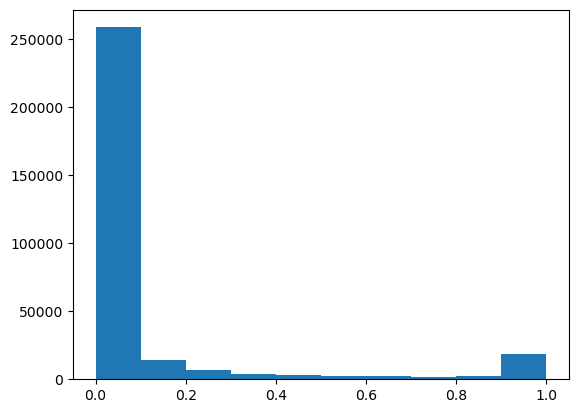

In [19]:
# ruunare due volte se printa schifezze
import matplotlib.pyplot as plt

# Coalesce the tensor to remove duplicate indices
att_coal = att.coalesce()

# Visualize the density of the non-zero values
plt.hist(att_coal.values().cpu().numpy(), bins=10)
plt.show()

Heatmap of attention

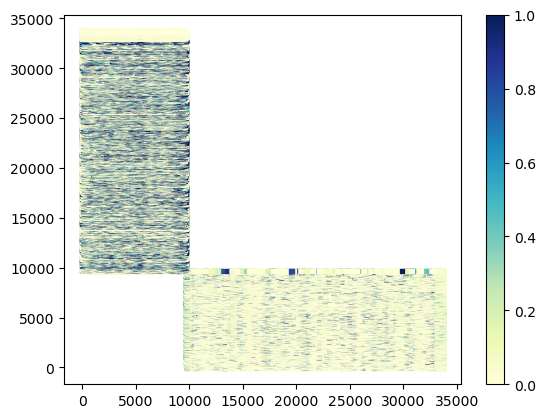

In [20]:
# Define a function to visualize the sparse tensor in COO format
def visualize_sparse_coo(tensor, marker='s', markersize=10):
    tensor = tensor.coalesce()
    indices = tensor.indices().cpu().numpy()
    values = tensor.values().cpu().numpy()
    plt.scatter(indices[1], indices[0], marker=marker, s=markersize, c=values, cmap='YlGnBu')

# Visualize the sparse tensor in COO format
visualize_sparse_coo(att)
plt.colorbar()
plt.show()

# check che user con alta attention abbiano pochi edge

## Attention analysis

1) Voglio collegare ogni film con i suoi generi a cui l'attenzione da maggiore importanza (e magari anche con attori e registi).

2) Voglio collegare ogni user ai film a cui l'attenzione da maggior peso, e confrontarli con quelli effettivamente piaciuti.

In [21]:
from sklearn.preprocessing import LabelEncoder
import pickle

# Encoders used in KGAT_datafile_construction.ipynb have to be imported to reconstruct user, items, metadata, relations
enc_dir = '/kaggle/input/kgat-data-movielens-final/KGAT data (10 in test, encoders)'

# metadata encoder (!!!! REMEMBER TO SUBTRACT max(df.movieId) to encodings before inverse transforming !!!!)
with open(enc_dir+'/metadata_encoder.pkl', 'rb') as f:
    metadata_encoder = pickle.load(f)

# Relations
with open(enc_dir+'/relation_encoder.pkl', 'rb') as f:
    relations_encoder = pickle.load(f)
    
# Users
with open(enc_dir+'/users_encoder.pkl', 'rb') as f:
    users_encoder = pickle.load(f)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [22]:
# 1) collegamento film-genere
print('Items: ',data.n_items)
print('Entities (item+metadata): ',data.n_entities)
print('Users: ',data.n_users)
print('Entities (item+metadata+users): ',data.n_users_entities)

Items:  9692
Entities (item+metadata):  33072
Users:  609
Entities (item+metadata+users):  33681


**We have available:**

data.train_kg_dict >> containing (h1: [(t1,r),(t2,r),...], h2: [(t1,r),(t2,r),...]) heads as keys and a list with its (tail,relation) as values 

data.train_relation_dict >> same format as above but relation as key and a list of its (head,tail) as values

data.train_user_dict >> for every user (as key), a list of its related items (as values)

**Work scheme:** 

For point 1) take for every film, its attention coefficients related to genres. After that sort the coefficients and take the 1,2, or 3 highest ones and see to which genres are associated. Repeat for starring and directors. Finally take the top10 attention coefficient related to any metadata and see which are.

For point 2) take for every user, its attention coefficients related to films, sort them and take the top 5 or 10 films. After that check if those users have relation with the resulting films

In [23]:
# Check the relations encodings
encoded_labels = [i for i in range(int((max(data.train_relation_dict.keys())-1)/2))]
relation_dict = {encoded_label: decoded_label for encoded_label, decoded_label in zip(encoded_labels, relations_encoder.inverse_transform(encoded_labels))}
print('The original relations encoded were (in the data construction file): ', relation_dict)
new_relation_dict = {0: 'liked', 1: 'was liked by'}
for key, value in relation_dict.items():
    new_relation_dict[key+2] = value
print('\n\n\nThe relations processed and used in KGAT: ', new_relation_dict, ' and the inverse relations after')

The original relations encoded were (in the data construction file):  {0: 'directed by', 1: 'has genre', 2: 'starring', 3: 'was released on'}



The relations processed and used in KGAT:  {0: 'liked', 1: 'was liked by', 2: 'directed by', 3: 'has genre', 4: 'starring', 5: 'was released on'}  and the inverse relations after


## Visualizing user top k

In [24]:
!pip install networkx

In [25]:
import matplotlib.pyplot as plt
import networkx as nx

train_user_dict = data.train_user_dict
test_user_dict = data.test_user_dict

def visualize_user_topk(model, user, k, cast=False, n_cast=2):
    usr = int(users_encoder.transform([user])) # Converting user to the id passed in train cf
    usr_kg = usr + data.n_entities # Converting user to the id in KG    

    # User ids used in train
    user_ids = list(data.train_user_dict.keys())
    # Item ids used in train
    item_ids = list(np.arange(data.n_items))
    
    
    att = model.A_in
    user_id = torch.LongTensor([usr_kg])
    
    att_items = torch.topk(att.index_select(0,user_id).to_dense(),k,dim=1).indices[0].tolist()
    att_genres = {}
    att_actors = {}
    att_directors = {}
    for i in att_items:
        att_genres[i] = [g for g in item_df[item_df.movieId==i].genres][0]
        att_actors[i] = item_df[item_df.movieId==i].starring.values[0][0:n_cast]
        att_directors[i] = item_df[item_df.movieId==i].directedBy.values[0][0]

    scores = model(user_ids,item_ids,mode='predict')
    scores = scores.cpu()

    flag = (np.array(user_ids) - data.n_entities) == usr
    s=scores[flag].detach().numpy()[0]
    
    item_train_ids = train_user_dict[usr_kg]
    mask = np.zeros(s.size, dtype=bool)
    mask[item_train_ids] = True
    s[mask] = -np.inf
    cf_scores = np.argsort(s)
    
    # Retrieving top-k recommended items for user=usr with their metadata
    rec_items = cf_scores[-k:]
    rec_genres = {}
    rec_actors = {}
    rec_directors = {}
    for i in rec_items:
        rec_genres[i] = [g for g in item_df[item_df.movieId==i].genres][0]
        rec_actors[i] = item_df[item_df.movieId==i].starring.values[0][0:n_cast]
        rec_directors[i] = item_df[item_df.movieId==i].directedBy.values[0]

    # Constructing a dataframe to generate the graph
    df_visual = pd.DataFrame(columns = ['h','r','t'])

    to_add = pd.DataFrame({'h': [user]*k, 
                           'r': ['usr-att-itm']*k, 
                           't': att_items})
    df_visual = pd.concat([df_visual, to_add], ignore_index=True)

    for i in att_items:
        to_add = pd.DataFrame({'h': [i]*len(att_genres[i]), 
                           'r': ['genre']*len(att_genres[i]), 
                           't': att_genres[i]})
        df_visual = pd.concat([df_visual, to_add], ignore_index=True)

    for i in rec_items:
        to_add = pd.DataFrame({'h': [i]*len(rec_genres[i]), 
                           'r': ['genre']*len(rec_genres[i]), 
                           't': rec_genres[i]})
        df_visual = pd.concat([df_visual, to_add], ignore_index=True)
        
    if not cast:
        # Creating mapping node-layer to plot the graph
        node_layers = {user: 0}
        for i in att_items:
            node_layers[i] = 1
        for g in df_visual[df_visual.r=='genre'].t:
            node_layers[g] = 2
        for i in rec_items:
            node_layers[i] = 3

        # Create the graph and plot
        G=nx.from_pandas_edgelist(df_visual, 'h', 't', create_using=nx.MultiDiGraph())
        nx.set_node_attributes(G, node_layers, 'layer')
        d = nx.get_node_attributes(G,'layer')
        colors = []
        for node in G:
            if d[node] == 0:
                colors.append('skyblue')
            elif d[node] == 1:
                colors.append('red')
            elif d[node] == 2:
                colors.append('yellow')
            else:
                colors.append('green')
        pos = nx.multipartite_layout(G, subset_key='layer')
        nx.draw(G, with_labels=True, node_color=colors, edge_color='grey', edge_cmap=plt.cm.Blues, pos = pos)
        # Define the labels and colors for the legend
        labels = ['User', 'Top attention', 'Genres', 'Top recommended']
        cols = ['skyblue', 'red', 'yellow', 'green']
        # Create a patch with a colored rectangle for each label
        patches = [plt.Rectangle((0,0),1,1, color=color) for color in cols]
        # Plot the legend with the patches and labels
        plt.legend(patches, labels)
        plt.show()
    ################ If we print cast and directors
    else:
        for i in att_items:
            to_add = pd.DataFrame({'h': [i]*len(att_actors[i]), 
                               'r': ['starring']*len(att_actors[i]), 
                               't': att_actors[i]})
            df_visual = pd.concat([df_visual, to_add], ignore_index=True)
            to_add = pd.DataFrame({'h': [i]*len(att_directors[i]), 
                               'r': ['director']*len(att_directors[i]), 
                               't': att_directors[i]})
            df_visual = pd.concat([df_visual, to_add], ignore_index=True)
        
        for i in rec_items:
            to_add = pd.DataFrame({'h': [i]*len(rec_actors[i]), 
                               'r': ['starring']*len(rec_actors[i]), 
                               't': rec_actors[i]})
            df_visual = pd.concat([df_visual, to_add], ignore_index=True)
            to_add = pd.DataFrame({'h': [i]*len(rec_directors[i]), 
                               'r': ['director']*len(rec_directors[i]), 
                               't': rec_directors[i]})
            df_visual = pd.concat([df_visual, to_add], ignore_index=True)

        # Creating mapping node-layer to plot the graph
        node_layers = {user: 0}
        for i in att_items:
            node_layers[i] = 1
        for g in df_visual[df_visual.r=='genre'].t:
            node_layers[g] = 2
        for i in rec_items:
            node_layers[i] = 4
        for g in df_visual[df_visual.r=='starring'].t:
            node_layers[g] = 3
        for g in df_visual[df_visual.r=='director'].t:
            node_layers[g] = 3

        # Create the graph and plot
        G=nx.from_pandas_edgelist(df_visual, 'h', 't', create_using=nx.MultiDiGraph())
        nx.set_node_attributes(G, node_layers, 'layer')
        d = nx.get_node_attributes(G,'layer')
        colors = []
        for node in G:
            if d[node] == 0:
                colors.append('skyblue')
            elif d[node] == 1:
                colors.append('red')
            elif d[node] == 2:
                colors.append('yellow')
            elif d[node] == 3:
                colors.append('purple')
            else:
                colors.append('green')
        pos = nx.multipartite_layout(G, subset_key='layer')
        nx.draw(G, with_labels=True, node_color=colors, edge_color='grey', edge_cmap=plt.cm.Blues, pos = pos)
        # Define the labels and colors for the legend
        labels = ['User', 'Top attention', 'Genres', 'Cast',  'Top recommended']
        cols = ['skyblue', 'red', 'yellow', 'purple', 'green']
        # Create a patch with a colored rectangle for each label
        patches = [plt.Rectangle((0,0),1,1, color=color) for color in cols]
        # Plot the legend with the patches and labels
        plt.legend(patches, labels)
        plt.show()

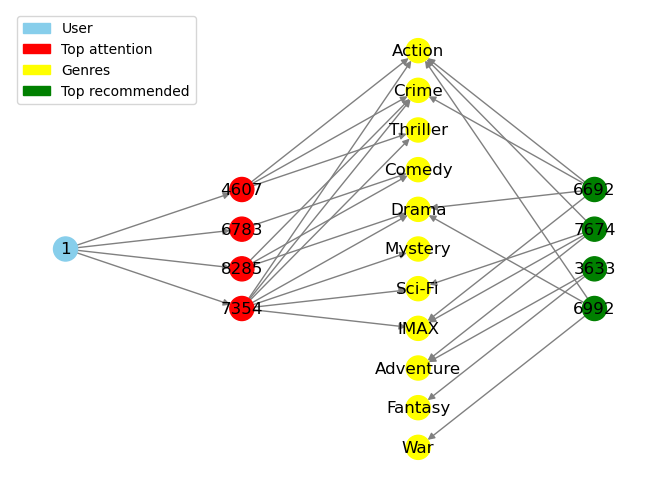

In [26]:
visualize_user_topk(model,user=1,k=4)

With directors

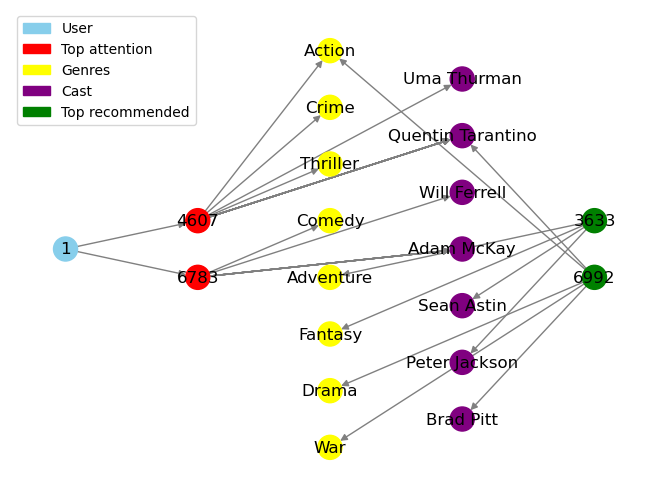

In [27]:
visualize_user_topk(model,user=1,k=2, cast=True, n_cast=1)

## Visualizing predictions densities and other properties

Users scores density plots

In [28]:
# User ids used in train
user_ids = list(data.test_user_dict.keys())
# Item ids used in train
item_ids = list(np.arange(data.n_items))

scores = model(user_ids,item_ids,mode='predict').detach().numpy()

sum(sum(np.isinf(scores)))

0

In [29]:
import seaborn as sns
import numpy as np

def plot_user_scores(scores, users=None):
    """
    Plots the density of the user scores for 3 randomly selected users or the users specified as input.

    Args:
        scores (numpy array): A 2D numpy array where each row corresponds to a user's scores.
        users (list of int, optional): A list of user indices to plot. If not specified, 3 random users will be plotted.
    """
    # If users are not specified, select 3 random users to plot
    if users is None:
        users = np.random.choice(scores.shape[0], size=3, replace=False)
    
    # Filter out any -Inf values from the scores array
    scores_filtered = np.ma.masked_equal(scores, -np.inf)
    
    # Loop over the selected users and create a density plot for each one using seaborn
    for user in users:
        user_scores = scores_filtered[user, :].compressed()
        sns.kdeplot(user_scores, label=f"User {user}")
    
    # Add plot labels and legend
    plt.xlabel("Score")
    plt.ylabel("Density")
    plt.legend()

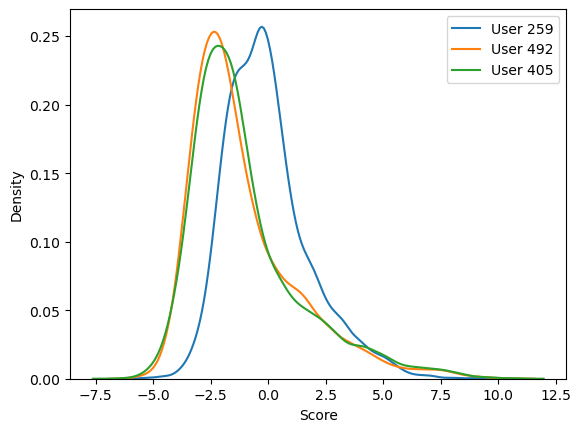

In [30]:
plot_user_scores(scores, users=None)

Users scores by item

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_user_scores_by_item(scores, users=None):
    """
    Plots the user scores for 3 randomly selected users or the users specified as input
    as a line plot, where the y-axis is the user scores and the x-axis is the item index.

    Args:
        scores (numpy array): A 2D numpy array where each row corresponds to a user's scores.
        users (list of int, optional): A list of user indices to plot. If not specified, 3 random users will be plotted.
    """
    # If users are not specified, select 3 random users to plot
    if users is None:
        users = np.random.choice(scores.shape[0], size=3, replace=False)
        
    items = np.arange(scores.shape[1])
    
    # Create a figure and axes object for the plot
    fig, ax = plt.subplots()

    # Loop over the selected users and create a line plot for each one using matplotlib
    for user in users:
        user_scores = scores[user, :]
        user_scores_filtered = np.ma.masked_equal(user_scores, -np.inf)
        item_indices = items[~user_scores_filtered.mask]
        user_scores_filtered = user_scores_filtered.compressed()
        item_indices = item_indices[item_indices <= 100]  # Filter out item indices greater than 50
        user_scores_filtered = user_scores_filtered[:len(item_indices)]
        ax.plot(item_indices, user_scores_filtered, label=f"User {user}")
    
    # Add plot labels and legend
    ax.set_xlabel("Item index")
    ax.set_ylabel("Score")
    ax.legend()

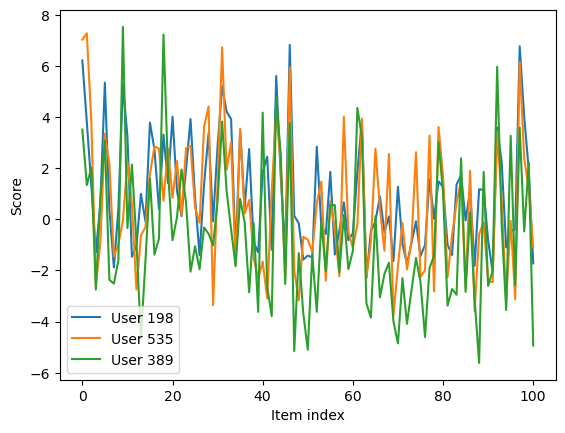

In [32]:
plot_user_scores_by_item(scores, users=None)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

# calculate cosine similarity between users
similarity_matrix = cosine_similarity(scores)

# print the similarity matrix
print(similarity_matrix)

[[1.0000002  0.28793308 0.5773062  ... 0.81807953 0.7363415  0.35961547]
 [0.28793308 1.0000001  0.26693085 ... 0.24267997 0.5122469  0.73894763]
 [0.5773062  0.26693085 1.0000001  ... 0.4326578  0.42028648 0.2949621 ]
 ...
 [0.81807953 0.24267997 0.4326578  ... 1.0000007  0.70730114 0.32281905]
 [0.7363415  0.5122469  0.42028648 ... 0.70730114 0.9999994  0.54809034]
 [0.35961547 0.73894763 0.2949621  ... 0.32281905 0.54809034 1.        ]]


# Prediction function

Given a user, return the top k recommended movies and a plot of the subgraph that led to this reccomendation (according to attention)

Dovrei creare embedding per nuovo user, usando la media degli embedding degli item che ha visto. Una volta creato l'embedding si può passare a KGAT per predizione. Se non ha visto niente??

In [34]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load data
data = DataLoaderKGAT(args, logging)
# Load model
model = KGAT(args, data.n_users, data.n_entities, data.n_relations)
model = load_model(model, args.pretrain_model_path)
model.to(device)

test_batch_size = data.test_batch_size
train_user_dict = data.train_user_dict
test_user_dict = data.test_user_dict

/kaggle/usr/lib/loader_kgat/loader_kgat.py:124: RuntimeWarning: divide by zero encountered in power
  d_inv = np.power(rowsum, -1.0).flatten()


In [35]:
all_embed = model.calc_cf_embeddings()
all_embed = model.calc_cf_embeddings()
user_embeds = all_embed[user_ids]
item_embed = all_embed[item_ids]

In [36]:
def subset_by_keys(keywords,df):
    item_df = df.drop_duplicates(subset=['movieId'])
    
    mask = item_df['genres'].apply(lambda x: any(i in x for i in keywords)) | \
           item_df['starring'].apply(lambda x: any(i in x for i in keywords)) | \
           item_df['directedBy'].apply(lambda x: any(i in x for i in keywords))

    # apply the mask to the dataframe to filter the rows
    subset_df = item_df[mask]
    items_subset = subset_df.movieId.values

    return items_subset

In [37]:
import time

def recommend(model, data, args, df, usr, k, keywords=None):
    """
    Compute the recommendation for a user (top k items), and plots the subgraph that led to this reccomendation (according to attention)

    Args:
        model (KGAT class): A trained KGAT model instance
        args (parser): The standard KGAT parser (careful on pre-trained model path and data path)
        user (int): The user to whom recommend items
        k (int): How many items to be recommended
        keywords(list): Optional, a list of keywords for a new user (genres, actors, directors for movielens)
    
    Output:
        rec (list of int): The top-k items recommended
        Moreover it will do the above mentioned plot
    """
    start_time = time.time()
    
    # Device
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device('cpu')
    model.to(device)

    test_batch_size = data.test_batch_size
    train_user_dict = data.train_user_dict
    test_user_dict = data.test_user_dict
     
    n_items = data.n_items
    item_ids = torch.arange(n_items, dtype=torch.long).to(device)
    user_ids = torch.tensor([i for i in train_user_dict], dtype=torch.long).to(device)
    
    if usr in users_encoder.classes_:
        user = users_encoder.transform([usr]) + data.n_entities # User encoded back to its kg encoding
        user_id = torch.LongTensor(user)
        if int(user) not in train_user_dict:
            raise Exception("Sorry user not in train_user_dict (check encdodings)")
        if int(user) in test_user_dict:
            print('User also in test')
        s = model(user_id, item_ids, mode='predict')
        s = s.cpu()
        s = np.array(s.detach().numpy()[0])
        item_train_ids = train_user_dict[int(user)]
        mask = np.ones(s.size, dtype=bool)
        mask[item_train_ids] = False
        s[mask] = -np.inf
        top_k = np.argsort(s)[-k:]
        print("the top-{} recommended items are: ".format(k),top_k.tolist())
        end_time = time.time()
        print(f"Execution time of pred: {end_time - start_time} seconds")
        # Top-k visualization
        start_time = time.time()
        visualize_user_topk(model, usr, k)
        end_time = time.time()
        print(f"Execution time of plot: {end_time - start_time} seconds")
    else:
        all_embed = model.calc_cf_embeddings()
        all_embed = model.calc_cf_embeddings()
        user_embeds = all_embed[user_ids]
        item_embed = all_embed[item_ids]
        user_embed = torch.median(user_embeds, 0).values
        if keywords is None:
            print("Nuovo utente, nessuna keyword")
            s = torch.matmul(user_embed, item_embed.transpose(0, 1)).detach().numpy()
            top_k = np.argsort(s)[-k:]
        else:
            print("Nuovo utente, keyword usate")
            subset_item_ids = subset_by_keys(keywords,df)
            s = torch.matmul(user_embed, item_embed.transpose(0, 1)).detach().numpy()
            mask = np.ones(s.size, dtype=bool)
            mask[subset_item_ids] = False
            s[mask] = -np.inf
            top_k = np.argsort(s)[-k:]
        print("the top-{} recommended items are (new user): ".format(k),top_k.tolist())
        end_time = time.time()
        print(f"Execution time of pred: {end_time - start_time} seconds")
    
    return top_k

User also in test
the top-4 recommended items are:  [224, 2392, 701, 520]
Execution time of pred: 0.06759953498840332 seconds


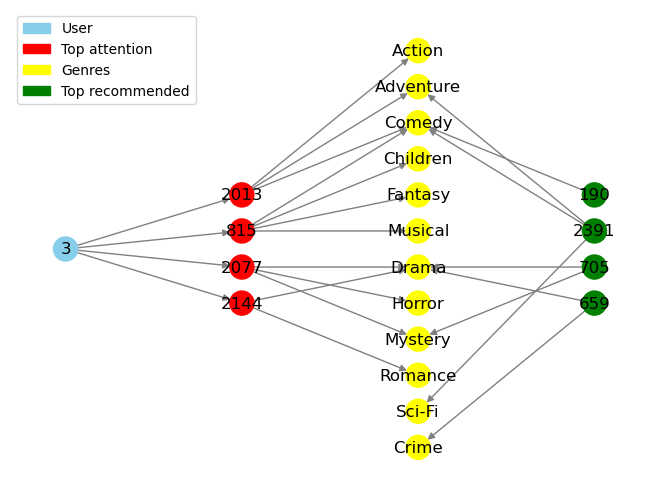

Execution time of plot: 0.7977180480957031 seconds


In [38]:
top_k = recommend(model, data, args, df, usr=3, k=4)

Recommend by keywords

In [39]:
top_k = recommend(model, data, args, df, usr=3000, k=3, keywords = ['Documentary'])

# Check on recommended items
item_df = df.drop_duplicates(subset=['movieId'])
item_df[item_df.movieId.isin(top_k)]

Nuovo utente, keyword usate
the top-3 recommended items are (new user):  [210, 5190, 4007]
Execution time of pred: 0.205183744430542 seconds


,userId,movieId,rating,timestamp,title,genres,release year,directedBy,starring,userId_old,movieId_old
1991,17,4007,4.0,1456919349,Bowling for Columbine,[Documentary],2002,[Michael Moore],"[Michael Moore, Charlton Heston, Dick Clark]",18,5669
3723,21,5190,1.0,1268726944,Super Size Me,"[Comedy, Documentary, Drama]",2004,[Morgan Spurlock],[Morgan Spurlock],22,8464
4955,31,210,4.0,856737338,Hoop Dreams,[Documentary],1994,[Steve James],"[Arthur Agee, Curtis Gates, William Gates, Emm...",32,246


Test on a prediction with new user, which are the films recommended? the most positively evaluated?

In [40]:
k=5
# Prediction on a new user
top_k = recommend(model, data, args, df, usr=2600, k=k)

# Print of most evaluated items
print(k,"most viewed items: ", [i for i in df.movieId.value_counts()[0:k].index])

Nuovo utente, nessuna keyword
the top-5 recommended items are (new user):  [510, 1938, 257, 277, 314]
Execution time of pred: 0.11936140060424805 seconds
5 most viewed items:  [314, 277, 257, 510, 1938]


They are the most seen movies

# Building a content based RS for new users

### TF-IDF

https://github.com/AlexanderNixon/Machine-learning-reads/blob/master/Movie-content-based-recommender-using-tf-idf.ipynb

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations

In [7]:
movies = item_df.drop(columns=['userId','rating'])
movies.head()

,movieId,timestamp,title,genres,release year,directedBy,starring,userId_old,movieId_old
0,0,964982703,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,[John Lasseter],"[Tim Allen, Tom Hanks, Don Rickles, Jim Varney...",1,1
1,2,964981247,Grumpier Old Men,"[Comedy, Romance]",1995,[Howard Deutch],"[Jack Lemmon, Walter Matthau, Ann-Margret, Sop...",1,3
2,5,964982224,Heat,"[Action, Crime, Thriller]",1995,[Michael Mann],"[Robert De Niro, Al Pacino, Val Kilmer, Jon Vo...",1,6
3,43,964983815,Seven (a.k.a. Se7en),"[Mystery, Thriller]",1995,[David Fincher],"[Brad Pitt, Morgan Freeman, Gwyneth Paltrow, J...",1,47
4,46,964982931,"Usual Suspects, The","[Crime, Mystery, Thriller]",1995,[Bryan Singer],"[Stephen Baldwin, Gabriel Byrne, Benicio Del T...",1,50


In [8]:
movies = movies.copy()  # create a copy of the original dataframe
movies['text'] = movies['genres'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['starring'].apply(lambda x: ' '.join(x)) + ' ' + \
                 movies['directedBy'].apply(lambda x: x[0] if len(x)>0 else '')

In [9]:
vectorizer = TfidfVectorizer()
vectorizer.fit(movies['text'])
tfidf_matrix = vectorizer.transform(movies['text'])

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

query = ['Action', 'Horror', 'Quentin Tarantino']
query_vector = vectorizer.transform([' '.join(query)])
similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

N = 10
top_indices = similarity_scores.argsort()[0][::-1][:N]
recommended_movies = movies.iloc[top_indices][['title','genres','release year','directedBy','starring']]
recommended_movies

,title,genres,release year,directedBy,starring
62,Reservoir Dogs,"[Crime, Mystery, Thriller]",1992,[Quentin Tarantino],"[Harvey Keitel, Tim Roth, Michael Madsen, Chri..."
3752,Death Proof,"[Action, Adventure, Crime, Horror, Thriller]",2007,[Quentin Tarantino],"[Kurt Russell, Zoe Bell, Rosario Dawson, Vanes..."
1900,Jackie Brown,"[Crime, Drama, Thriller]",1997,[Quentin Tarantino],"[Pam Grier, Samuel L. Jackson, Robert Forster,..."
69780,Sukiyaki Western Django,"[Action, Western]",2008,[Takashi Miike],"[Hideaki Ito, Masanobu Ando, Quentin Tarantino]"
16,Pulp Fiction,"[Comedy, Crime, Drama, Thriller]",1994,[Quentin Tarantino],"[John Travolta, Samuel L. Jackson, Tim Roth, A..."
242,Inglourious Basterds,"[Action, Drama, War]",2009,[Quentin Tarantino],"[Brad Pitt, Mélanie Laurent, Christoph Waltz, ..."
1509,Kill Bill: Vol. 2,"[Action, Drama, Thriller]",2004,[Quentin Tarantino],"[Uma Thurman, David Carradine, Michael Madsen,..."
253,Django Unchained,"[Action, Drama, Western]",2012,[Quentin Tarantino],"[Jamie Foxx, Christoph Waltz, Leonardo DiCapri..."
236,Kill Bill: Vol. 1,"[Action, Crime, Thriller]",2003,[Quentin Tarantino],"[Uma Thurman, David Carradine, Daryl Hannah, M..."
5,From Dusk Till Dawn,"[Action, Comedy, Horror, Thriller]",1996,[Robert Rodriguez],"[George Clooney, Quentin Tarantino, Harvey Kei..."


In [13]:
import numpy as np
from scipy.sparse import csr_matrix

# create a mapping of movieId to index
movie_index_map = {movieId: i for i, movieId in enumerate(movies['movieId'])}

# create a sparse adjacency matrix of movies
adj_matrix = csr_matrix((df['rating'], ([df['userId'], [movie_index_map[movieId] for movieId in df['movieId']]])))

# normalize the adjacency matrix
row_sums = np.array(adj_matrix.sum(axis=1)).flatten()
row_indices, col_indices = adj_matrix.nonzero()
adj_matrix.data /= row_sums[row_indices]

# set the damping factor to 0.85
damping_factor = 0.85

# initialize the PageRank scores
pr = np.ones(len(movies)) / len(movies)

# iterate until convergence
while True:
    pr_new = (1 - damping_factor) / len(movies) + damping_factor * adj_matrix.dot(pr)
    if np.allclose(pr, pr_new):
        break
    pr = pr_new

# compute the Personalized PageRank scores for each user and movie
user_item_scores = {}
for userId in df['userId'].unique():
    user_movies = df[df['userId'] == userId]['movieId'].unique()
    user_scores = np.zeros(len(movies))
    for movieId in user_movies:
        if movieId in movie_index_map:
            movie_index = movie_index_map[movieId]
            user_scores += pr[movie_index] * cosine_sim[movie_index]
    user_item_scores[userId] = user_scores


NameError: name 'user_idx_map' is not defined

In [ ]:
# Pesare gli item -- con set ottimale di domande -- in base alla similiarità dei film csotruire ei aring fittizi

# Permutation of attention

Attention permutation from paper "attention is not explanation", algorithm 2.

In [42]:
# Shuffling attenzione NON usando to_dense (esempio)
import torch

# create a sparse tensor
indices = torch.tensor([[0, 1, 1, 2], [1, 0, 1, 2]])
values = torch.tensor([3, 1, 2, 4])
sparse_tensor = torch.sparse_coo_tensor(indices, values, size=(3, 3))

num_values = sparse_tensor._values().numel()
shuffled_indices = torch.randperm(sparse_tensor._values().numel())
shuffled_values = sparse_tensor._values().index_select(0, shuffled_indices)
shuffled_sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), shuffled_values, sparse_tensor.size())
print(sparse_tensor,'\n', shuffled_sparse_tensor)

tensor(indices=tensor([[0, 1, 1, 2],
                       [1, 0, 1, 2]]),
       values=tensor([3, 1, 2, 4]),
       size=(3, 3), nnz=4, layout=torch.sparse_coo) 
 tensor(indices=tensor([[0, 1, 1, 2],
                       [1, 0, 1, 2]]),
       values=tensor([2, 1, 3, 4]),
       size=(3, 3), nnz=4, layout=torch.sparse_coo)


In [43]:
def shuffle_sparse_tensor(sparse_tensor):
    num_values = sparse_tensor._values().numel()
    shuffled_indices = torch.randperm(sparse_tensor._values().numel())
    shuffled_values = sparse_tensor._values().index_select(0, shuffled_indices)
    shuffled_sparse_tensor = torch.sparse_coo_tensor(sparse_tensor._indices(), shuffled_values, sparse_tensor.size())
    return shuffled_sparse_tensor

In [44]:
model.A_in

Parameter containing:
tensor(indices=tensor([[    0,     0,     0,  ..., 33680, 33680, 33680],
                       [ 9776, 10001, 11009,  ...,  9421,  9422,  9423]]),
       values=tensor([4.1597e-02, 8.4001e-05, 5.0734e-05,  ...,
                      1.9830e-05, 2.0997e-05, 1.2927e-04]),
       size=(33681, 33681), nnz=313038, layout=torch.sparse_coo)

In [45]:
shuffle_sparse_tensor(model.A_in)

tensor(indices=tensor([[    0,     0,     0,  ..., 33680, 33680, 33680],
                       [ 9776, 10001, 11009,  ...,  9421,  9422,  9423]]),
       values=tensor([1.0000e+00, 6.0303e-03, 1.1667e-04,  ...,
                      7.8000e-03, 1.1637e-01, 1.3970e-02]),
       size=(33681, 33681), nnz=313038, layout=torch.sparse_coo)

In [46]:
model.entity_user_embed.weight

Parameter containing:
tensor([[ 0.5005, -0.0971, -0.1351,  ..., -0.2501,  0.1061,  0.1664],
        [ 0.0432, -0.3511,  0.1388,  ..., -0.1430,  0.5089, -0.0161],
        [-0.0110,  0.1518,  0.1639,  ..., -0.5509, -0.2264,  0.5676],
        ...,
        [-0.2667, -0.4676, -0.0323,  ..., -0.7753, -0.7183,  0.3717],
        [-0.0026, -0.4435,  0.0980,  ..., -0.2918,  0.0639, -0.2960],
        [ 0.4834, -0.8356,  0.9369,  ..., -0.5523, -0.6594,  0.8682]],
       requires_grad=True)

In [47]:
import torch.nn.functional as F
def calc_cf_embeddings(model, perm=False):
    ego_embed = model.entity_user_embed.weight
    all_embed = [ego_embed]
    if perm:
        attention = shuffle_sparse_tensor(model.A_in)
        for i in range(10):
            attention = shuffle_sparse_tensor(attention)
    else:
        attention = model.A_in
    for idx, layer in enumerate(model.aggregator_layers):
        ego_embed = layer(ego_embed, attention)
        norm_embed = F.normalize(ego_embed, p=2, dim=1)
        all_embed.append(norm_embed)

    # Equation (11)
    all_embed = torch.cat(all_embed, dim=1)         # (n_users + n_entities, concat_dim)
    return all_embed

In [48]:
calc_cf_embeddings(model, perm=False)

tensor([[ 0.5005, -0.0971, -0.1351,  ..., -0.4309, -0.2855,  0.2764],
        [ 0.0432, -0.3511,  0.1388,  ..., -0.3824, -0.2176,  0.2584],
        [-0.0110,  0.1518,  0.1639,  ..., -0.6374, -0.4237, -0.0287],
        ...,
        [-0.2667, -0.4676, -0.0323,  ..., -0.3287, -0.1372,  0.2969],
        [-0.0026, -0.4435,  0.0980,  ..., -0.4081, -0.1862, -0.0564],
        [ 0.4834, -0.8356,  0.9369,  ..., -0.1150,  0.1331,  0.4164]],
       grad_fn=<CatBackward0>)

In [49]:
calc_cf_embeddings(model, perm=True)

tensor([[ 0.5005, -0.0971, -0.1351,  ..., -0.6926, -0.3653, -0.0921],
        [ 0.0432, -0.3511,  0.1388,  ..., -0.6421, -0.4043, -0.0312],
        [-0.0110,  0.1518,  0.1639,  ..., -0.6642, -0.3687,  0.0206],
        ...,
        [-0.2667, -0.4676, -0.0323,  ..., -0.8808, -0.2743, -0.1561],
        [-0.0026, -0.4435,  0.0980,  ..., -0.6243, -0.0765, -0.0012],
        [ 0.4834, -0.8356,  0.9369,  ..., -0.0599, -0.0328, -0.0449]],
       grad_fn=<CatBackward0>)

In [50]:
"""
Domanda: io non ho una probabilità per un link tra un utente e un oggetto 
ma uno score assegnato all'oggetto. Come calcolo la differenza tra output? 
Non è più tra 0 e 1 in questo caso. Come posso far vedere che gli output sono differenti.
"""

train_user_dict = data.train_user_dict
test_user_dict = data.test_user_dict

n_items = data.n_items
item_ids = torch.arange(n_items, dtype=torch.long)
user_ids = torch.tensor([i for i in train_user_dict], dtype=torch.long)
all_embed = calc_cf_embeddings(model, perm=False)
user_embeds = all_embed[user_ids]
item_embeds = all_embed[item_ids]
yhat = torch.matmul(user_embeds, item_embeds.transpose(0, 1)).detach().numpy()

n_perm = 100
corr = []
jaccard = []
for p in range(n_perm):
    all_embed = calc_cf_embeddings(model, perm=True)
    user_embeds = all_embed[user_ids]
    item_embeds = all_embed[item_ids]
    yperm = torch.matmul(user_embeds, item_embeds.transpose(0, 1)).detach().numpy()
    corr.append(np.corrcoef(yhat.flatten(), yperm.flatten())[0][1])
    jaccard.append(np.sum(np.minimum(yhat, yperm)) / np.sum(np.maximum(yhat, yperm)))
print(sum(np.array(corr)>0.8))
print(sum(np.array(jaccard)>1.5))

100
100


In [51]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcolo la cosine similarity tra i due tensori
cos_sim = cosine_similarity(yhat, yperm)
print("Cosine similarity:\n", cos_sim)

Cosine similarity:
 [[0.9217782  0.23271248 0.48843592 ... 0.694321   0.42202514 0.3133968 ]
 [0.19564798 0.92565876 0.16865548 ... 0.4503107  0.49197173 0.6880253 ]
 [0.3657182  0.15534219 0.8340523  ... 0.2088072  0.26407138 0.10275762]
 ...
 [0.64276886 0.4321579  0.28957564 ... 0.9290028  0.44891483 0.4958415 ]
 [0.53743845 0.39069837 0.30014274 ... 0.5410675  0.8572521  0.30736396]
 [0.27712658 0.63946193 0.19900942 ... 0.49063128 0.29908305 0.93279463]]


Correlazione di Pearson: 0.9136591736777279
Indice di similarità di Jaccard: 3.010691


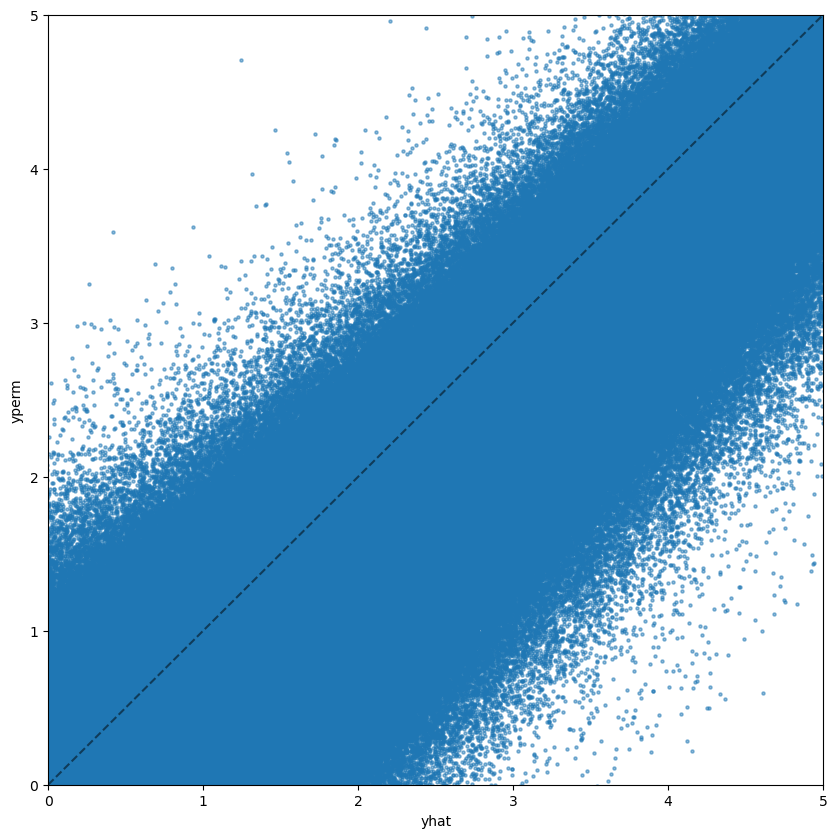

In [52]:
# Calcolo la correlazione di Pearson tra i due tensori
corr = np.corrcoef(yhat.flatten(), yperm.flatten())[0][1]
print("Correlazione di Pearson:", corr)

# Calcolo l'indice di similarità di Jaccard tra i due tensori
jaccard = np.sum(np.minimum(yhat, yperm)) / np.sum(np.maximum(yhat, yperm))
print("Indice di similarità di Jaccard:", jaccard)

# Visualizzazione dei due tensori
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(yhat.flatten(), yperm.flatten(), alpha=0.5, s=5)
ax.set_xlabel('yhat')
ax.set_ylabel('yperm')
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.plot(ax.get_xlim(), ax.get_ylim(), linestyle='--', color='k', alpha=0.5)
plt.show()